# HOMEWORK 04

**Submitted by: Diego Sol**

CSCE 636-600: Deep Learning

Professor: Dr. Anxiao Jiang

## Task 1

**Check out the Jupyter notebook for Chapter 7 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter07_working-with-keras.ipynb . Answer the questions: (1) What is the advantage of using  Sequential Models? (2) What is the advantage of using Functional API? (3) What is the advantage of using Subclassing? (5 points)**

###Advantages of using Sequential Models:
- it is simplest and easiest model to use
- many problems are readily solved without having to define any methods or classes
- it automatically matches input and ouptut sizes between layers
- the `summary()` method can be used to depict an easily interpretable summary of the model

###Advantages of using Functional API:
- it provides more control over the model than when using a Sequential Model
- unlike Sequential Models, it can be used to create layers with multiple inputs and outputs
- it represents a good midpoint between usability and flexibility
- the `plot_model()` method can be used to draw a plot that depicts the inputs and outputs to all the layers in the model

###Advantages of using Subclassing:
- of all the listed model-developing options, this one provides that highest degree control and accessibility
- it allows for user-defined metrics such as loss
- the new class automatically inherits methods and variables from the `keras.model` class
- it allows for precise customization of steps throughout the training process

## Task 2

**For the MNIST Dataset (for handwritten digit recognition), in the past, we built a one-input-one-output model, where the input is an image, and the output is a length-10 vector that represents a probability vector for the 10 classes (from class 0 to class 9). Today, let's build a one-input-multiple-output model, which has 10 outputs y_0, y_1, y_2, ..., y_9, where each y_i (for i between 0 and 9) is a real number between 0 and 1 that represents the probability for the input image to belong to class i. (That is, the probability that the input image does not belong to class i is 1 - y_i.) In other words, this new model is a combination of 10 binary classifiers (that is, one binary classifier for each class). The loss function for each y_i is the binary cross-entropy function, and the overall loss for the model is the summation of the 10 binary cross-entropies.**

**Let's define a new performance metric "aggregateAccuracy" as follows. First, we pick y_i\* to be the maximum value among y_0, y_1, y_2, ..., y_9. Then, we let i\* be the label that our model predicts for the input image. Then, "aggregateAccuracy" is simply the "accuracy" that we usually talk about: it is the fraction of images whose predicted label equals the true label.**

**Now compile your model and train it (with the loss function and performance metric defined above), and test the trained model's performance on the testing data.** 

**What you need to submit: (1) the complete code; (2) the training performance for training data and validation data (for both loss and aggregationAccuracy) shown in figures, where the x-axis is the number of epochs, and the y-axis is the loss or aggregateAccuracy; (3) show the test performance (loss and aggregateAccuracy) as two numbers. (15 points)**

Import packages and load MNIST data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# load data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# prepare image data (reshape and normalize)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

# number of labels
num_labels = len(np.unique(train_labels))

# prepare label data to meet task requirements
for ii in range(num_labels):
  exec(f"train_labels_{ii} = np.zeros(train_labels.shape)")
  exec(f"test_labels_{ii} = np.zeros(test_labels.shape)")

  idx_train = np.where(train_labels == ii)
  idx_test = np.where(test_labels == ii)

  for jj in idx_train[0]:
    exec(f"train_labels_{ii}[{jj}] = 1")
  
  for kk in idx_test[0]:
    exec(f"test_labels_{ii}[{kk}] = 1")

# each array in the list is a multi-hot encode that depicts
train_labels_list = [train_labels_0, train_labels_1, train_labels_2, train_labels_3,\
                     train_labels_4, train_labels_5, train_labels_6, train_labels_7,\
                     train_labels_8, train_labels_9]

test_labels_list = [test_labels_0, test_labels_1, test_labels_2, test_labels_3,\
                    test_labels_4, test_labels_5, test_labels_6, test_labels_7,\
                    test_labels_8, test_labels_9]

11501568/11490434 [==============================] - 1s 0us/step


In [2]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Write a new performance metric

In [3]:
class Aggregate_Accuracy(keras.metrics.Metric):    
    def __init__(self, name="aggregateAccuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_total = self.add_weight(name="num_total", initializer="zeros", dtype="int32")
        self.num_accurate = self.add_weight(name="num_accurate", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
      self.num_total = tf.cast(tf.shape(y_pred,0), "int32")
      y_pred = tf.reshape(tf.argmax(y_pred, axis=0), shape=(-1, 1))
      y_true = tf.reshape(tf.argmax(y_true, axis=0), shape=(-1, 1))
      values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
      values = tf.cast(values, "int32")
      self.num_accurate.assign(tf.reduce_sum(values))

    def result(self):
      return tf.cast(self.num_accurate / self.num_total, "float32")

    def reset(self):
      self.num_total.assign(0.)
      self.num_accurate.assign(0.)

Create a single-input multiple-output network by using the Functional API

In [4]:
# input size
image_shape = train_images.shape[1]

# single input
inputs = keras.Input(shape=(image_shape,), name="input")

# 2 hidden layers 
layer_1 = layers.Dense(64, activation="relu", name="layer_1")(inputs)
layer_2 = layers.Dense(64, activation="relu", name="layer_2")(layer_1)

# 10 output layers
y_list = []
loss_list = []
metrics_list = []

for ii in range(num_labels):
  exec(f"y_{ii} = layers.Dense(1, activation=\"sigmoid\", name=\"y_{ii}\")(layer_2)")
  exec(f"y_list.append(y_{ii})")
  loss_list.append("binary_crossentropy")
  metrics_list.append(["accuracy"])

# create model
model = keras.Model(inputs=inputs, outputs=y_list)

# compilation
model.compile(optimizer="rmsprop",
              loss=loss_list,
              metrics=metrics_list)#Aggregate_Accuracy())

# train the model
history = model.fit(train_images, train_labels_list,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.4)

Epoch 1/15
282/282 [==============================] - 23s 48ms/step - loss: 1.1433 - y_0_loss: 0.0778 - y_1_loss: 0.0717 - y_2_loss: 0.1175 - y_3_loss: 0.1272 - y_4_loss: 0.1131 - y_5_loss: 0.1391 - y_6_loss: 0.0860 - y_7_loss: 0.0947 - y_8_loss: 0.1678 - y_9_loss: 0.1483 - y_0_accuracy: 0.9778 - y_1_accuracy: 0.9782 - y_2_accuracy: 0.9623 - y_3_accuracy: 0.9601 - y_4_accuracy: 0.9614 - y_5_accuracy: 0.9531 - y_6_accuracy: 0.9724 - y_7_accuracy: 0.9685 - y_8_accuracy: 0.9401 - y_9_accuracy: 0.9507 - val_loss: 0.5937 - val_y_0_loss: 0.0329 - val_y_1_loss: 0.0320 - val_y_2_loss: 0.0811 - val_y_3_loss: 0.0720 - val_y_4_loss: 0.0518 - val_y_5_loss: 0.0813 - val_y_6_loss: 0.0327 - val_y_7_loss: 0.0504 - val_y_8_loss: 0.0837 - val_y_9_loss: 0.0757 - val_y_0_accuracy: 0.9905 - val_y_1_accuracy: 0.9905 - val_y_2_accuracy: 0.9766 - val_y_3_accuracy: 0.9776 - val_y_4_accuracy: 0.9827 - val_y_5_accuracy: 0.9707 - val_y_6_accuracy: 0.9897 - val_y_7_accuracy: 0.9829 - val_y_8_accuracy: 0.9723 - val

Plot the model

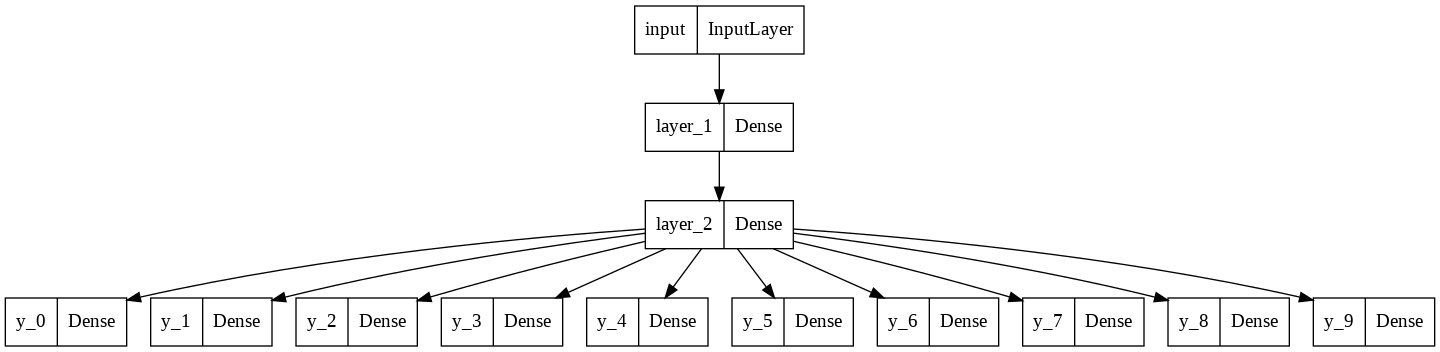

In [5]:
keras.utils.plot_model(model)

In [8]:
# history data
history_dict = history.history

# training metric history
train_loss_values = history_dict["loss"]
train_acc_values = history_dict["y_0_accuracy"]

# validation metric history
val_loss_values = history_dict["val_loss"]
val_acc_values = history_dict["val_y_0_accuracy"]

# epochs
epochs = range(1, len(train_loss_values) + 1)

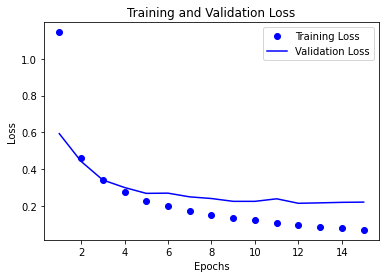

In [9]:
# create figure for training data
fig1, ax1 = plt.subplots()

# plot
ax1.plot(epochs, train_loss_values, "bo", label="Training Loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation Loss")
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
plt.show()

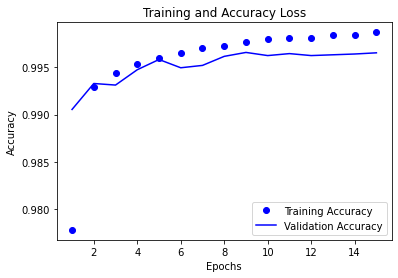

In [10]:
# create figure for training data
fig2, ax2 = plt.subplots()

# plot
ax2.plot(epochs, train_acc_values, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc_values, "b", label="Validation Accuracy")
ax2.set_title("Training and Accuracy Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

Evaluate on the test set

In [11]:
results = model.evaluate(test_images,test_labels_list)

313/313 [==============================] - 8s 26ms/step - loss: 0.1857 - y_0_loss: 0.0135 - y_1_loss: 0.0105 - y_2_loss: 0.0193 - y_3_loss: 0.0257 - y_4_loss: 0.0163 - y_5_loss: 0.0169 - y_6_loss: 0.0170 - y_7_loss: 0.0213 - y_8_loss: 0.0209 - y_9_loss: 0.0242 - y_0_accuracy: 0.9964 - y_1_accuracy: 0.9972 - y_2_accuracy: 0.9940 - y_3_accuracy: 0.9919 - y_4_accuracy: 0.9946 - y_5_accuracy: 0.9947 - y_6_accuracy: 0.9944 - y_7_accuracy: 0.9925 - y_8_accuracy: 0.9937 - y_9_accuracy: 0.9925


Separate losses and accuracies, then average them out

In [12]:
indiv_loss = results[:10]
indiv_accuracy = results[10:]

avg_loss = np.mean(indiv_loss)
avg_accuracy = np.mean(indiv_accuracy)

print(f"Network loss: {avg_loss}")
print(f"Network accuracy: {avg_accuracy}")

Network loss: 0.034725184086710215
Network accuracy: 0.9060119446367025
